# The $N$-body problem. Maximum: 80 pts + 25 bonus pts

## Problem 0 (Problem statement) 5 pts

Consider the $N$-body problem
$$
    V({\bf y}_j) = \sum_{i=1}^N G({\bf x}_i, {\bf y}_j) q_i, \quad j=1,\dots,N,
$$
where ${\bf x}_i$ is the location of source charges and ${\bf y}_j$ is the location of receivers where the potential $V$ is measured. 
For simplicity in this pset sources and receivers are the same points: ${\bf x}_i = {\bf y}_i$, $i=1,\dots,N$.
The naive summation yields $\mathcal{O}(N^2)$ complexity, which is prohibitive if $N$ is large.
This problem set is devoted to algorithms that break the $\mathcal{O}(N^2)$.


* (5 pts) Name algorithms that break $\mathcal{O}(N^2)$ for $N$-body problem. Specify their complexities. Estimate how much memory and what time requires to estimate all $N$ potentials $V({\bf y}_j)$ for $N=300$ billion particles with naive $\mathcal{O}(N^2)$ summation and $\mathcal{O}(N\log N)$, $\mathcal{O}(N)$ algorithms on a supercomputer
(constants hidden in $\mathcal{O}$ can be found in lectures).



## Problem 1 (The Barnes-Hut algorithm and beyond) 35 pts + 25 bonus pts

#### The Barnes-Hut

The Barnes-Hut (BH) idea is quite simple. First, we separate our particles in a quad-tree structure of particle groups. If the group on some tree level is sufficiently far away from a certain particle, we can approximate its potential by using its center of mass. If it is not, we compute its influence recursively by using lower tree levels. The accuracy of the Barnes-Hut algorithm depends on the choise of parameter $\theta = s / d$, where $s$ is the width of the region represented by the internal node, and $d$ is the distance between the body and the node's center-of-mass.

* (10 pts) Propose an algorithm for the quadtree construction. Can you reach $\mathcal{O}(N)$ memory for the storage? Propose a way to store the tree and write the program that computes the tree, given the location of the particles. What do you need to store in each node of the tree?

### Solution

We can implement a quad-tree for arbitrary dimension $d$. Create a class called TreeNode which contains node's mass, coordinate and size of bounding box. Put there also a list of children (there are not so many of them for quad-tree, no more than $2^d$), each child is set to be another TreeNode (if the node is a leaf, its children array is empty). 

Suppose there are $N=4^K, K \in N$ particles. If the number of particles is not a power of $4$, then we claim that the tree for $4^{Ceil(\text{log}_4N)}$ is not smaller than one constructed from $N$ particles, so we can round $N$ to closest(on the right) power of $4$ and obtain a valid upper bound. The total numer of nodes then is

$$
N + N/4 + N/16 +...+ 1 = N (1+ 1/4 + 1/16 +...+4^{-K}) \leq \frac{4}{3} N
$$

with use of geometric series. Hence, memory complexity is $O(N)$.

* (20 pts) Implement Barnes-Hut algorithm. The program should consist of three parts:
    1.  Tree construction given the location of the particles and geometric constant $\theta$  
    2.  Filling the information in the tree (computing the charges and geometric centers)
    3. Computing the product

* (5 pts) Compare the results computed by direct evaluation and Barnes-Hut algorithm. Make sure that you got linear complexity. Study the dependance of accuracy and computational cost on the geometric parameter $\theta$


The code is very direct and follows the instruction given here. For clarity I implemented quadtrees and their construction in python module with similar name and Barnes-Hut summation routines in module simplebh. The summation algorithm takes coordinates $x$, masses $m$, interaction function $interFun$ and separability parameter $\theta$ which is called $farParameter$ in my code. 

In order to compare the algorithm with direct multiplication I measure execution time and memory requirements for quadtree. For simplicity consider 2D case. Since the performance of Barnes-Hut algorithm is very structure dependent, the random testing scheme is proposed. For each $N$ a problem instance with $x,m$ is generated. Locations are obtained from gaussian mixture with several random centers and uniformly distributed masses are assigned to particles (see the $Generation$ function below). There are $N_{exp}$ experiments for each $N$, we are interested in average performance.

Note that numpy matrix multiplication is far more faster than native python code, so the execution times are just incomparable. For this reason I put the curves in the separate subplots.


In [1]:
## THE CODE
#imports 
import numpy as np
import quadtrees as qtrees
import simplebh as sbh
import simplebh as sbh
import numpy as np
import quadtrees as qtrees
import sklearn.datasets.samples_generator as skdat
import matplotlib.pyplot as plt
%matplotlib inline
# to not run previous sections

import mybootstrap as boots #bootstrap module
import time as pytime #for time measurements
import tqdm #preloader

#JUPYTER NOTEBOOK THEMES,              JUST FOR MY NOTEBOOK
# delete this if native theme is ok,
from jupyterthemes import jtplot
# choose which theme to inherit plotting style from\n",
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd\n",
jtplot.style(theme='oceans16')
# set \"context\" (paper, notebook, talk, poster)\n",
# scale font-size of ticklabels, legend, etc.\n",
# remove spines from x and y axes and make grid dashed\n",
jtplot.style(context='talk', fscale=1.4, spines=True, gridlines='--')

In [28]:
def GravInteraction(m0,m1,x0,x1): #interaction function
    try:
        #kronecker shit
        x0k=np.kron(np.ones([1,x1.shape[1]]),x0)
        x1k=np.kron(x1,np.ones([1,x0.shape[1]]))
        res=m0*m1/np.reshape( np.linalg.norm(x1k-x0k,ord=2,axis=0), (x0.shape[1],x1.shape[1]))
        return res
    except:
        return m0*m1/np.linalg.norm(x1-x0,2,axis=0)**2
    
def GenerateInstance(N,maxClusters=5,minMass=2,maxMass=20): #instance generator
    #Generates N particles in plane
    #first sets up a number of clusters
    #then generates centers
    #finally, generates something similar to GaussianMixture
    
    clustNumber = np.random.randint(1,maxClusters+1)
    centers = np.random.randn(clustNumber,2)*200
    # Generate sample data
    X, _ = skdat.make_blobs(n_samples=N, centers=centers, cluster_std=50)
    X=X.T
    masses=np.random.uniform(minMass,maxMass,size=N)
    return X,masses

In [7]:
#CAREFUL IT MIGHT WORK VERY LONG!!
N0=50 
N1=300
Ns = np.arange(N0,N1+10,10)

NExp=100 # enough?

timesBH=np.zeros([NExp,Ns.shape[0]])
memsBH=np.zeros([NExp,Ns.shape[0]])
timesDirect=np.zeros([NExp,Ns.shape[0]])

for i in tqdm.tqdm(np.arange(Ns.shape[0])): #Experiment
    for expId in np.arange(NExp):
        xs,ms = GenerateInstance(Ns[i])
        
        #check memory requirement for QTree
        treeRoot = qtrees.TreeNode()#root
        treeRoot = qtrees.ConstructTree(xs,ms,treeRoot,level=0)
        memsBH[expId,i]= treeRoot.getNumberOfNodes()
        
        #BH summation
        time0=pytime.time()
        bhSum = sbh.BHSummation(xs,ms,GravInteraction,farParameter=3)    
        timesBH[expId,i]=pytime.time()-time0
        
        #DirectSummation
        time0=pytime.time()
        F= GravInteraction(ms[:,np.newaxis],ms[np.newaxis,:], xs, xs)
        F[np.diag(np.ones([Ns[i]])).astype('bool')]=0 # avoid Infinities on the diagonal
        justSum=F @ np.ones([Ns[i]])
        timesDirect[expId,i]=pytime.time()-time0
        #print(np.linalg.norm(bhSum-justSum,2))

  0%|                                                   | 0/26 [00:00<?, ?it/s]d:\programs\anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
100%|██████████████████████████████████████████| 26/26 [08:00<00:00, 18.48s/it]


In [15]:
#SAVE/LOAD from pickle
import pickle

#WRITE
#with open('BHExperimentalData.pkl','wb') as f:
#    dat = {'Ns':Ns,'timesDirect':timesDirect, 'timesBH':timesBH, 'memsBH':memsBH}
#    pickle.dump(dat, f)
    
#READ
with open('BHExperimentalData.pkl','rb') as f:
    dat = pickle.load(f)
    Ns= dat['Ns']
    timesBH = dat['timesBH']
    timesDirect = dat['timesDirect']
    memsBH = dat['memsBH']
    

Now let us present the experimental results. First, time complexity.

Text(0,0.5,'log(T)')

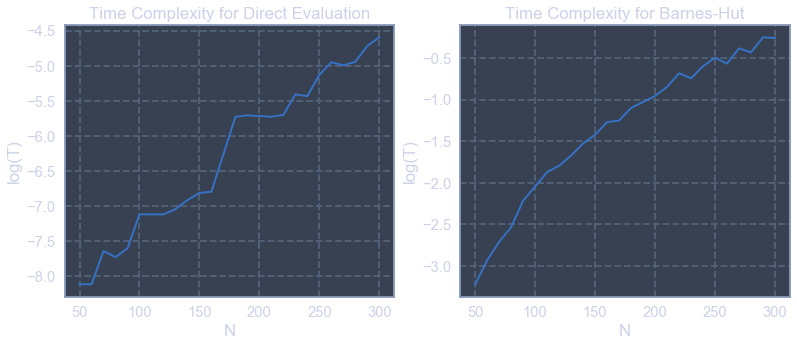

In [22]:
#Plots
f,(ax1,ax2) =plt.subplots(1,2,figsize=(13,5))

ax1.plot(Ns,np.log(np.mean(timesDirect,axis=0)))
ax1.set_title('Time Complexity for Direct Evaluation')
ax1.set_xlabel('N')
ax1.set_ylabel('log(T)')

ax2.plot(Ns,np.log(np.mean(timesBH,axis=0)))
ax2.set_title('Time Complexity for Barnes-Hut')
ax2.set_xlabel('N')
ax2.set_ylabel('log(T)')

From these charts we can observe that direct evaluation time grows approximately as $N^2$ while Barnes-Hut is definetely better than $N^2$. As to memory requirement, Barnes-Hut demands linear memory for tree storage and constant memory for computations.

Text(0,0.5,'Number of Nodes')

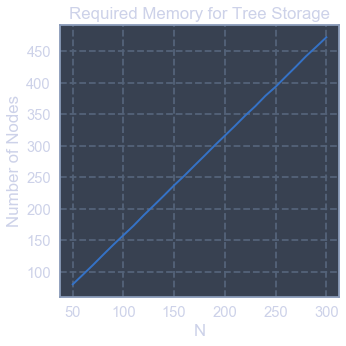

In [27]:
f,ax =plt.subplots(figsize=(5,5))

ax.plot(Ns,np.mean(memsBH,axis=0))
ax.set_title('Required Memory for Tree Storage')
ax.set_xlabel('N')
ax.set_ylabel('Number of Nodes')

In the same way we could study the algorithm in dependence of $\theta$. Fix some relatively usual number of particles and perform experiments for several theta.

In [40]:
#CAREFUL IT MIGHT WORK VERY LONG!!
N=300
thetas = np.arange(1,17,0.5)

NExp=100 # enough?

timesBH=np.zeros([NExp,thetas.shape[0]])
sumErrors=np.zeros([NExp,thetas.shape[0]])

for i in tqdm.tqdm(np.arange(thetas.shape[0])): #Experiment
    for expId in np.arange(NExp):
        xs,ms = GenerateInstance(N)

        #BH summation
        time0=pytime.time()
        bhSum = sbh.BHSummation(xs,ms,GravInteraction,farParameter=thetas[i])    
        timesBH[expId,i]=pytime.time()-time0
        
        #DirectSummation
        F= GravInteraction(ms[:,np.newaxis],ms[np.newaxis,:], xs, xs)
        F[np.diag(np.ones([N])).astype('bool')]=0 # avoid Infinities on the diagonal
        justSum=F @ np.ones([N])
        sumErrors[expId,i]=np.linalg.norm(bhSum-justSum,2)


  0%|                                                   | 0/32 [00:00<?, ?it/s]d:\programs\anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
100%|███████████████████████████████████████| 32/32 [1:25:31<00:00, 160.37s/it]


In [41]:
#SAVE/LOAD from pickle

#WRITE
#with open('BHExperimentalDataThetas.pkl','wb') as f:
#    dat = {'thetas':thetas,'sumErrors':sumErrors, 'timesBH':timesBH}
#    pickle.dump(dat, f)
    
#READ
with open('BHExperimentalDataThetas.pkl','rb') as f:
    dat = pickle.load(f)
    thetas= dat['thetas']
    timesBH = dat['timesBH']
    sumErrors = dat['sumErrors']


Text(0,0.5,'log(T)')

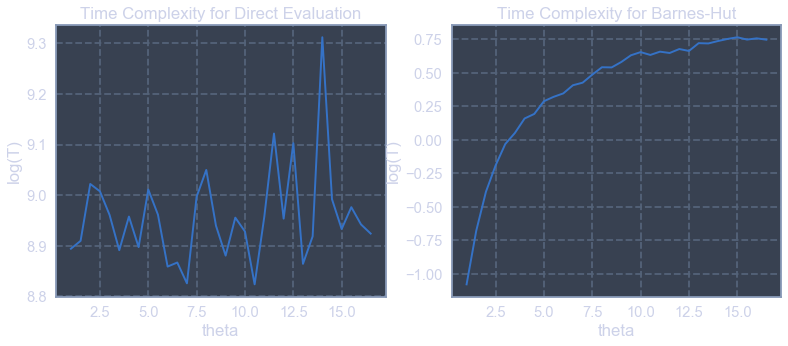

In [42]:
#Plots
f,(ax1,ax2) =plt.subplots(1,2,figsize=(13,5))

ax1.plot(thetas,np.log(np.mean(sumErrors,axis=0)))
ax1.set_title('Time Complexity for Direct Evaluation')
ax1.set_xlabel('theta')
ax1.set_ylabel('log(T)')

ax2.plot(thetas,np.log(np.mean(timesBH,axis=0)))
ax2.set_title('Time Complexity for Barnes-Hut')
ax2.set_xlabel('theta')
ax2.set_ylabel('log(T)')

#### Simplified FMM (Bonus task)

In order to break $\log$ term in $\mathcal{O}(N \log N)$ for the Barnes-Hut algorithm a second tree can be used. 
This almost leads us to the FMM algorithm with only one exception: only one term in the multipole expansion is used.

* (20 pts) Now that you are a given a tree from the previous task, code the Barnes-Hut with two trees. The key differences are:
    1. You need to create the interaction list
    2. You also need to build M2L and L2L operators (in standard BH only M2M operator is used)
 
 
* (5 pts) Compare performance and accuracy of the standard and 2-tree BH. Which one is faster?

## Problem 2 (40 pts)

Consider an ideally conducting sphere $\Omega\subset\mathbb{R}^3$, which is attached to a $1$ V battery.

- (5 pts) Write first kind Fredholm integral equation on $\partial \Omega$

- (20 pts) Using [BEM++](https://bempp.com/) write a Python program solves this integral equation

- (10 pts) Write a function that evaluates potenital from the obtained solution at the given point of $\mathbb{R}^3$

- (5 pts) Plot the depenedce of the potential on a half-line from the center of the sphere. Compare it with the analytical solution by plotting obtained solution for different number of grid points and the analytic solution on one plot

In [ ]:
#BEMPP code here!